# Experimentation notebook for trying to improve Redbox `RAG chat`  <a class="anchor" id="title"></a>

-----------

**Evaluate Redbox RAG chat on one stable, numbered version of these data**

-----------------------

## Table of Contents <a class="anchor" id="toc"></a>
* [Overview](#overview)
* [Metrics](#metrics)
    - [Contextual Precisio]()
    - [Contextual Recall]()
    - [Contextual Relevancy]()
    - [Fathfulness]()
    - [Answer Relevancy]()
    - [Hallucination]()
    
**CODE STARTS HERE**
* [Set version of the evaluation dataset](#setversion)
* [Imports](#imports)
* [Run Redbox Locally](#run-redbox)

**EXPERIMENTATION**
* [Get files that correspond to the version of evaluation dataset](#files)
* [Load Evaluation Dataset into test cases](#load-test-cases)
* [Generate `actual_output` using RAG and evaluation dataset](#evaluate)
    - [Retrieval Evaluation Metrics]()
    - [Generation Evaluation Metrics]()
* [Analyse evaluation results](#analysis)

------------

## Overview <a class="anchor" id="overview"></a>

This notebook allows you to experiment with the retrieval and generation parts of Redbox RAG chat **WITHIN** the notebook, and get back evaluation metrics quickly. This allows you to test if the changes you make can improve the evaluation metrics, compared against the current/deployed RAG chat endpoint.

************

Redbox RAG chat is made up of many components that work together to give the final RAG pipeline. Each component can be optimised, to hopefully improve the over all performance of the RAG pipeline for Redbox tasks. In order to track if changes made are improving or degrading Redbox performance, we need to establish an evaluation framework. The overall RAG pipeline can be broken down into two main parts:

1. Retrieval - searching and returning the most relevant documents to answer a user question
2. Generation - the ouput of the LLM after considering the retrieved documents, any prompts provided and the user question

This notebook tests both the retrieval and generation sides of the RAG pipeline using specific metrics for each, using the `DeepEval` framework.


For consistency across the team, it is important to evaluate Redbox RAG chat on one stable, numbered version of these data.


[Back to top](#title)


-------

## Metrics <a class="anchor" id="metrics"></a>

Retrieval metrics
- Contextual Precision
- Contextual Recall
- Contextual Relevancy

Generation metrics
- Faithfulness
- Answer Relevancy
- Hallucination


### Contextual Precision

The contextual precision metric measures your RAG pipeline's retriever by evaluating whether nodes in your `retrieval_context` that are relevant to the given `input` are ranked higher than irrelevant ones.

### Contextual Recall

The contextual recall metric measures the quality of your RAG pipeline's retriever by evaluating the extent of which the `retrieval_context` aligns with the `expected_output`.

### Contextual Relevancy

The contextual relevancy metric measures the quality of your RAG pipeline's retriever by evaluating the overall relevance of the information presented in your `retrieval_context` for a given `input`.

### Faithfulness

The faithfulness metric measures the quality of your RAG pipeline's generator by evaluating whether the `actual_output` factually aligns with the contents of your `retrieval_context`. `deepeval`'s faithfulness metric is a self-explaining LLM-Eval, meaning it outputs a reason for its metric score.

##### Required Arguments
To use the `FaithfulnessMetric`, you need to provide the following arguments when creating an LLMTestCase:

- `input`
- `actual_output`
- `retrieval_context`

[Back to top](#title)

### Answer Relevancy
The answer relevancy metric measures the quality of your RAG pipeline's generator by evaluating how relevant the actual_output of your LLM application is compared to the provided `input`. `deepeval`'s answer relevancy metric is a self-explaining LLM-Eval, meaning it outputs a reason for its metric score.

##### Required Arguments
To use the AnswerRelevancyMetric, you'll have to provide the following arguments when creating an LLMTestCase:

- `input`
- `actual_output`

[Back to top](#title)

### Hallucination
The hallucination metric determines whether your LLM generates factually correct information by comparing the `actual_output` to the provided `context`.

##### Required Arguments
To use the HallucinationMetric, you'll have to provide the following arguments when creating an LLMTestCase:

- `input`
- `actual_output`
- `retrieval_context`

[Back to top](#title)

-------------------

**Evaluate Redbox RAG chat on one stable, numbered version of these data**

**Set the version of the evaluation dataset you are using to evalute Redbox in the cell below**   <a class="anchor" id="setversion"></a>

In [1]:
DATA_VERSION = "0.2.0"

Run the cell below to set up the required folder structure (it will not overwrite folders and files if they already exist)

In [2]:
from pathlib import Path

ROOT = Path.cwd().parents[1]
EVALUATION_DIR = ROOT / "notebooks/evaluation"

V_ROOT = EVALUATION_DIR / f"data/{DATA_VERSION}"
V_RAW = V_ROOT / "raw"
V_SYNTHETIC = V_ROOT / "synthetic"
V_CHUNKS = V_ROOT / "chunks"
V_RESULTS = V_ROOT / "results"

V_ROOT.mkdir(parents=True, exist_ok=True)
V_RAW.mkdir(parents=True, exist_ok=True)
V_SYNTHETIC.mkdir(parents=True, exist_ok=True)
V_CHUNKS.mkdir(parents=True, exist_ok=True)
V_RESULTS.mkdir(parents=True, exist_ok=True)

To save on API costs, we only need to generate a particular version of the evaluation dataset once. If you are using a previously generaterated evalutation dataset, **please download it from shared team location (Google Drive).**

---------

#### Imports <a id="imports"></a>

In [3]:
# Add autoreloatd
%reload_ext autoreload
%autoreload 2

In [4]:
from jose import jwt
from uuid import UUID
import requests
import json
import pandas as pd
import pickle
from dataclasses import asdict
from IPython.display import clear_output

In [5]:
from dotenv import find_dotenv, load_dotenv
_ = load_dotenv(find_dotenv())

[Back to top](#title)

-----------------

## Start Redbox locally <a id="run-redbox"></a>

Start docker runtime, likely with Docker Desktop. However, if you are using colima run the following terminal command

```bash
colima start --memory 8
``` 

---------------------

#### First-time setup

First time users need to do the following

```bash
poetry install
```

Ensure you .env file has OpenAI API key in and has the following settings:

```bash
# === Object Storage ===

MINIO_HOST=minio
MINIO_PORT=9000
MINIO_ACCESS_KEY=minioadmin
MINIO_SECRET_KEY=minioadmin
AWS_ACCESS_KEY=minioadmin
AWS_SECRET_KEY=minioadmin

AWS_REGION=eu-west-2

# minio or s3
OBJECT_STORE=minio
BUCKET_NAME=redbox-storage-dev
```

Build redbox docker images (this takes several minutes)

```bash
docker compose build
```

------

#### Build containers

If changes are made to the app, e.g. changes pulled in from main, it may require rebuilding docker images

```bash
docker compose build --no-cache
```

#### Run Redbox locally

**Every time you start Redbox for evaluation (no Django frontend required), please run the following command**

```bash
make eval_backend
````

The above command will bring up everything you need for the backend (`core-api`, `worker`, `mino`, `elasticsearch` and `redis`), then create the MinIO bucket needed to store raw files

[Back to top](#title)

----------

# EXPERIMENTATION

Use code below to experiment, in order to improve evaluation metrics or address a performance issue

For setting an initial baseline with the existing Redbox Core API endpoint, please start [HERE](#baseline)

If you've already uploaded documents you can skip to [the experimentation phase](#evaluate).

## Generate `actual_output` using RAG chat function and evaluation dataset

We first need to upload files that we are going to 'RAG with'

#### Get files that correspond to the version of evaluation dataset  <a class="anchor" id="files"></a>

Copy all the files that match your {DATA_VERSION} into `notebooks/evaluation/data/{DATA_VERSION}/raw/`. Find these files on the shared Google Drive and the corresponding version number/location

**It is really important to use the same files that were used to genearte this particular version of the evaluation dataset. A mismatch between the two will result in inaccurate evaluatoin metrics**

**Only if you haven't uploaded files already** uncomment and run cells below

In [ ]:
bearer_token = jwt.encode({"user_uuid": str(UUID("aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa"))}, key="your-secret-key", algorithm="HS512")
print(bearer_token)

In [ ]:
# url = 'http://127.0.0.1:5002/file/upload'

# headers={
#     'accept': 'application/json',
#     "Authorization": f"Bearer {bearer_token}"
# }
# for file in V_RAW.glob("*.*"):
#     files = {'file': open(file, 'rb')}
#     upload_file_response = requests.post(url, headers=headers, files=files)

#     #TODO: Add some login in the loop to deal with status codes != 200
#     # if upload_file_response.status_code != 200:
#     #     print("Failed to upload data:", upload_file_response.status_code)

List files uploaded to server & view JSON response

In [ ]:
url = 'http://127.0.0.1:5002/file/'

headers={
    'accept': 'application/json',
    "Authorization": f"Bearer {bearer_token}"
}

file_list_response = requests.get(url, headers=headers)

if file_list_response.status_code == 200:
    # Parse JSON from the response
    data = file_list_response.json()
    
    # Pretty-print the JSON data
    pretty_json = json.dumps(data, indent=4)
    print(pretty_json)
else:
    print("Failed to retrieve data:", file_list_response.status_code)

Get file status

In [ ]:
import os
cwd = os.getcwd()
os.chdir('../../')
from redbox.models import FileStatus
os.chdir(cwd)

def pretty_upload_status(file_uuid: UUID, bearer_token: str) -> str:
    headers={
        'accept': 'application/json',
        "Authorization": f"Bearer {bearer_token}"
    }
    status = FileStatus(**requests.get(f"http://127.0.0.1:5002/file/{file_uuid}/status", headers=headers).json())

    status_title = status.processing_status.title()
    n_chunks = 0
    if status.chunk_statuses is not None:
        n_chunks = len(status.chunk_statuses)

    if status.processing_status == "embedding" and n_chunks > 0 and status.chunk_statuses is not None:
        n_chunks_embedded = len([chunk for chunk in status.chunk_statuses if chunk.embedded])
        return f"{status_title} ({n_chunks_embedded / n_chunks:.0%})"
    else:
        return status_title

statuses = [pretty_upload_status(file["uuid"], bearer_token) for file in file_list_response.json()]
statuses

------------

**Please ensure all emeddings have been completed before proceeding!**

Keep calm and go for a tea break!

--------------

#### Generate `actual_output` and `retrieval_context` using in-notebook `rag_chat()` function <a id="evaluate"></a>

In [ ]:
df = pd.read_csv(f'{V_SYNTHETIC}/ragas_synthetic_data.csv')
inputs = df['input'].tolist()

##### Using a `rag_chat()` function

We can conceptualise RAG as having four mechanisms we might tune:

* Chunking
* Embedding
* Retriever
* Prompts

The below `rag_chat()` function replicates the internal logic of the RAG endpoint. By editing and using it here, you can quickly iterate and test the retriever and prompt mechanisms using your stable, versioned data, giving sharable, reproducible results.

As long as `rag_chat()` takes a question (and history) and produces an answer, it's a testable process that could be used in Redbox. Everything within the function is yours to play with -- prompts, retriever, everything.

**Set the experiment name that you want to associate with your experiment in the cell below** - this will save the output scores with this experiment in the file name

In [ ]:
EXPERIMENT_NAME = "simple_prompt"

In [ ]:
from redbox.models import Settings

from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_elasticsearch import ApproxRetrievalStrategy, ElasticsearchStore
from langchain_community.chat_models import ChatLiteLLM
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.chains.llm import LLMChain
from langchain.prompts.prompt import PromptTemplate
from langchain.globals import set_verbose

set_verbose(False)

# Core variables

ENV = Settings()
ENV.elastic.host = "localhost"
LLM = ChatLiteLLM(
    model="gpt-3.5-turbo",
    streaming=True,
)
EMBEDDING_MODEL = SentenceTransformerEmbeddings(model_name=ENV.embedding_model)
VECTOR_STORE = ElasticsearchStore(
    es_connection=ENV.elasticsearch_client(),
    index_name="redbox-data-chunk",
    embedding=EMBEDDING_MODEL,
    strategy=ApproxRetrievalStrategy(hybrid=False),
    vector_query_field="embedding",
)
RETRIEVER = VECTOR_STORE.as_retriever(
    search_kwargs={
        "filter": {
            "term": {
                "creator_user_uuid.keyword": str(UUID("aaaaaaaa-aaaa-aaaa-aaaa-aaaaaaaaaaaa"))
            }
        }
    }
)

# Prompts

"""You are RedBox Copilot. An AI focused on helping UK Civil Servants, Political Advisors and\
Ministers triage and summarise information from a wide variety of sources. You are impartial and\
non-partisan. You are not a replacement for human judgement, but you can help humans\
make more informed decisions. If you are asked a question you cannot answer based on your following instructions, you\
should say so. Be concise and professional in your responses. Respond in markdown format."""


WITH_SOURCES_PROMPT = """You are RedBox Copilot. If you are asked a question you cannot answer based on your following instructions, you\
should say so. Be concise and professional in your responses. Respond in markdown format.

=== RULES ===

All responses to Tasks **MUST** be translated into the user's preferred language.\
This is so that the user can understand your responses.\
Given the following extracted parts of a long document and \
a question, create a final answer with Sources at the end.  \
If you don't know the answer, just say that you don't know. Don't try to make \
up an answer.
Be concise in your response and summarise where appropriate. \
At the end of your response add a "Sources:" section with the documents you used. \
DO NOT reference the source documents in your response. Only cite at the end. \
ONLY PUT CITED DOCUMENTS IN THE "Sources:" SECTION AND NO WHERE ELSE IN YOUR RESPONSE. \
IT IS CRUCIAL that citations only happens in the "Sources:" section. \
This format should be <DocX> where X is the document UUID being cited.  \
DO NOT INCLUDE ANY DOCUMENTS IN THE "Sources:" THAT YOU DID NOT USE IN YOUR RESPONSE. \
YOU MUST CITE USING THE <DocX> FORMAT. NO OTHER FORMAT WILL BE ACCEPTED.
Example: "Sources: <DocX> <DocY> <DocZ>"

Use **bold** to highlight the most question relevant parts in your response.
If dealing dealing with lots of data return it in markdown table format.

QUESTION: {question}
=========
{summaries}
=========
FINAL ANSWER:"""

STUFF_DOCUMENT_PROMPT = "<Doc{parent_doc_uuid}>{page_content}</Doc{parent_doc_uuid}>"

CONDENSE_QUESTION_PROMPT = """Given the following conversation and a follow up question,
rephrase the follow up question to be a standalone question, in its original
language. include the follow up instructions in the standalone question.

Chat History:
{chat_history}
Follow Up Input: {question}
Standalone question:"""

# RAG function

def rag_chat(question: str, previous_history: list[tuple[str, str]] | None = None) -> str:
    docs_with_sources_chain = load_qa_with_sources_chain(
        LLM,
        chain_type="stuff",
        prompt=PromptTemplate.from_template(WITH_SOURCES_PROMPT),
        document_prompt=PromptTemplate.from_template(STUFF_DOCUMENT_PROMPT),
        verbose=True,
    )

    condense_question_chain = LLMChain(
        llm=LLM, 
        prompt=PromptTemplate.from_template(CONDENSE_QUESTION_PROMPT),
        verbose=False
    )

    standalone_question = condense_question_chain(
        {"question": question, "chat_history": previous_history}
    )["text"]

    docs = RETRIEVER.get_relevant_documents(standalone_question)

    result = docs_with_sources_chain(
        {
            "question": standalone_question,
            "input_documents": docs,
        },
    )

    source_documents = [
        {
            "page_content": langchain_document.page_content,
            "file_uuid": langchain_document.metadata.get("parent_doc_uuid"),
            "page_numbers": langchain_document.metadata.get("page_numbers"),
        }
        for langchain_document in result.get("input_documents", [])
    ]

    return {
        "output_text": result["output_text"],
        "source_documents": source_documents
    }


In [ ]:
%%capture

df_function = df.copy()

retrieval_context = []
actual_output = []

for question in inputs:
    data = rag_chat(question=question, previous_history=None)

    retrieval_context.append(data['source_documents'])
    actual_output.append(data['output_text'])

df_function['actual_output'] = actual_output
df_function['retrieval_context'] = retrieval_context

clear_output()

#### Confirm `actual_output` and `retrieved_context` added to the dataframe

In [ ]:
df_function.head()

#### Remove rows containing NaN to prevent Pydantic validation errors

In [ ]:
df_function_clean = df_function.dropna()
df_function_clean.to_csv(f'{V_SYNTHETIC}/{EXPERIMENT_NAME}_complete_ragas_synthetic_data.csv', index=False)

[Back to top](#title)

----

## Load Evaluation Dataset into test cases <a class="anchor" id="load-test-cases"></a>

Put the CSV file that you want to use for evaluation into `/notebooks/evaluation/data/synthetic_data/` directory

Import test cases from CSV

In [ ]:
from deepeval.dataset import EvaluationDataset

dataset = EvaluationDataset()
dataset.add_test_cases_from_csv_file(
    file_path=f'{V_SYNTHETIC}/{EXPERIMENT_NAME}_complete_ragas_synthetic_data.csv', # function
    input_col_name="input",
    actual_output_col_name="actual_output",
    expected_output_col_name="expected_output",
    context_col_name="context",
    context_col_delimiter= ";",
    retrieval_context_col_name="retrieval_context",
    retrieval_context_col_delimiter= ";"
)

[Back to top](#title)

---------

## Evaluate RAG pipeline <a id="evaluate"></a>

DeepEval imports

In [ ]:
from deepeval import evaluate
from deepeval.metrics import (
    ContextualPrecisionMetric,
    ContextualRecallMetric,
    ContextualRelevancyMetric,
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    HallucinationMetric,
)

Instantiate retrieval and generation evaluation metrics

In [ ]:
# Instantiate retrieval metrics
contextual_precision = ContextualPrecisionMetric(
    threshold=0.5, # default is 0.5
    model="gpt-4o",
    include_reason=True
)

contextual_recall = ContextualRecallMetric(
    threshold=0.5, # default is 0.5
    model="gpt-4o",
    include_reason=True
)

contextual_relevancy = ContextualRelevancyMetric(
    threshold=0.5, # default is 0.5
    model="gpt-4o",
    include_reason=True
)

In [ ]:
# Instantiate generation metrics
answer_relevancy = AnswerRelevancyMetric(
    threshold=0.5, # default is 0.5
    model="gpt-4o",
    include_reason=True
)

faithfulness = FaithfulnessMetric(
    threshold=0.5, # default is 0.5
    model="gpt-4o",
    include_reason=True
)

hallucination = HallucinationMetric(
    threshold=0.5, # default is 0.5
    model="gpt-4o",
    include_reason=True
)

#### View test cases

In [ ]:
dataset.test_cases

#### Evaluation

In [ ]:
eval_results = evaluate(
    test_cases=dataset,
    metrics=[
        contextual_precision,
        contextual_recall,
        contextual_relevancy,
        answer_relevancy,
        faithfulness,
        hallucination
    ]
)

#### Save evaluation results

In [ ]:
with open(f"{V_RESULTS}/{EXPERIMENT_NAME}_generation_eval_results", "wb") as f:
    pickle.dump(eval_results, f)

In [ ]:
with open(f"{V_RESULTS}/{EXPERIMENT_NAME}_generation_eval_results", "rb") as f:
    eval_results = pickle.load(f)

-------

## Analyse evaluation results <a id="analysis"></a>

In [ ]:
metric_type = {
    "metric_name": ["Contextual Precision", "Contextual Recall", "Contextual Relevancy", "Answer Relevancy", "Faithfulness", "Hallucination"],
    "metric_type": ["retrieval", "retrieval", "retrieval", "generation", "generation", "generation"]
}

evaluation = (
    pd.DataFrame.from_records(
        asdict(result) for result in eval_results
    )
    .explode("metrics")
    .reset_index(drop=True)
    .assign(
        metric_name = lambda df: df.metrics.apply(getattr, args=["__name__"]),
        score = lambda df: df.metrics.apply(getattr, args=["score"]),
        reason = lambda df: df.metrics.apply(getattr, args=["reason"])
    )
    .merge(
        pd.DataFrame(metric_type),
        on="metric_name"
    )
    .drop(columns=["success"])
)

evaluation.to_csv(f"{V_RESULTS}/{EXPERIMENT_NAME}_generation_eval_results.csv", index=False)
evaluation.head()

#### Evaluation results

In [ ]:
(
    evaluation
    .groupby(["metric_name", "metric_type"])
    .mean("score")
)

### Compare experiments against baseline or visualise baseline alone

  experiment_name           metric_name      mean       sem  count    ci_low  \
0        baseline      Answer Relevancy  0.957937  0.021817     10  0.908583   
1        baseline  Contextual Precision  0.805556  0.103935     10  0.570438   
2        baseline     Contextual Recall  0.763333  0.095865     10  0.546471   
3        baseline  Contextual Relevancy  0.516667  0.141530     10  0.196503   
4        baseline          Faithfulness  0.966667  0.033333     10  0.891261   
5        baseline         Hallucination  0.180000  0.109341     10 -0.067348   

    ci_high  
0  1.007290  
1  1.040673  
2  0.980195  
3  0.836831  
4  1.042072  
5  0.427348  


<Axes: xlabel='score', ylabel='metric_name'>

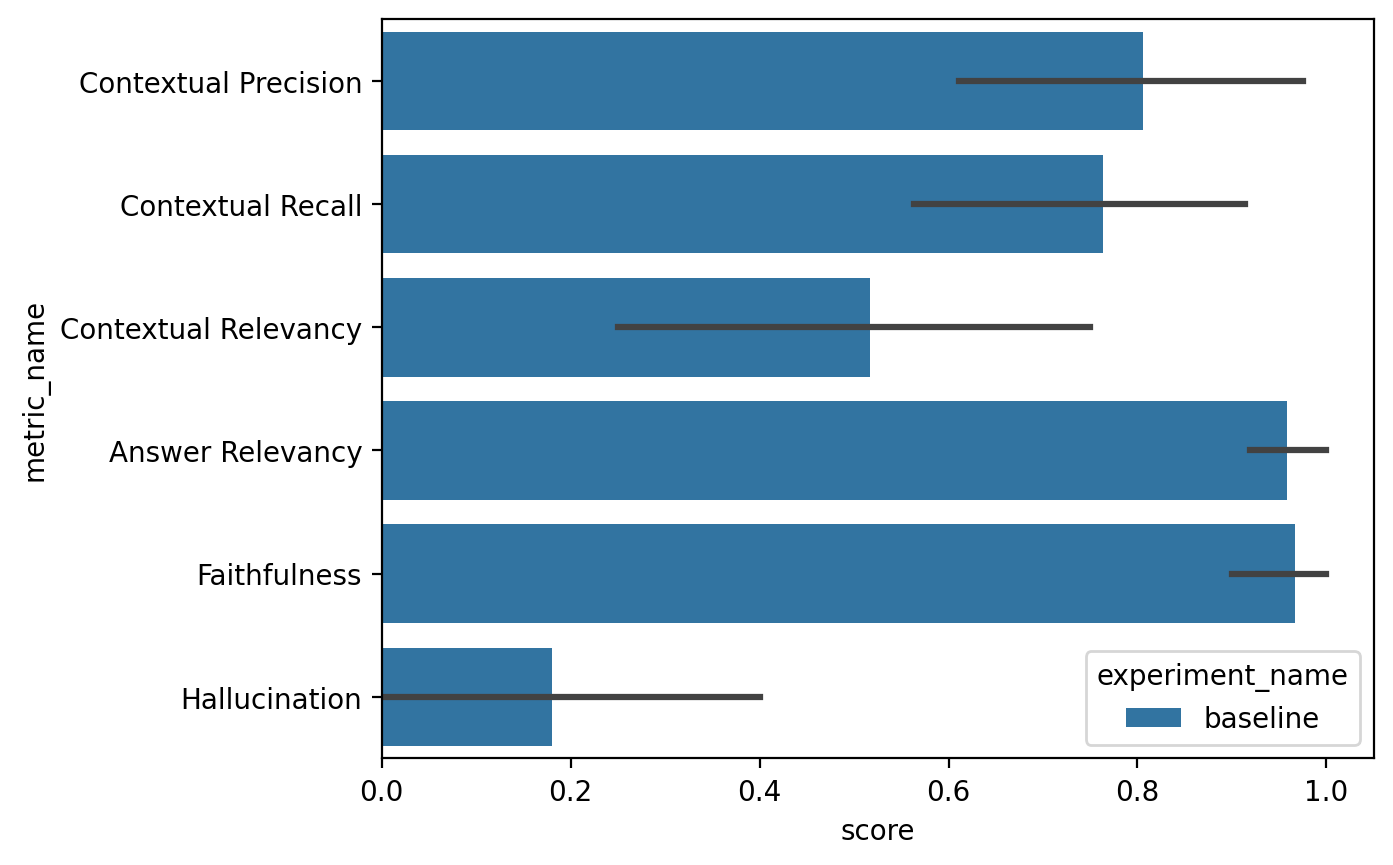

In [109]:
%config InlineBackend.figure_format = 'retina'
import scipy.stats as stats
import seaborn as sns

experiments = []

baseline = pd.read_csv(f"{V_RESULTS}/baseline.csv")
baseline['experiment_name'] = 'baseline'
experiments.append(baseline)

# # Comment out if you only want to view baseline statistics
# experiment_names = ['simple_prompt']
# for experiment_name in experiment_names:
#     experiment = pd.read_csv(f"{V_RESULTS}/{experiment_name}_generation_eval_results.csv")
#     experiment['experiment_name'] = experiment_name
#     experiments.append(experiment)

experiments_df = pd.concat(experiments)

def empirical_ci(df):

    df_grouped = (df
                  .groupby(["experiment_name", "metric_name"])['score']
                  .agg(["mean", 'sem', 'count'])
                  .reset_index()
                  )
    
    ci = stats.t.interval(confidence=0.95, 
                          df=df_grouped['count']-1,
                          loc=df_grouped['mean'],
                          scale=df_grouped['sem'])

    df_grouped['ci_low'] = ci[0]
    df_grouped['ci_high'] = ci[1] 

    return df_grouped

print(empirical_ci(experiments_df))

# Note that the confidence intervals in sns.barplot is calculated by bootstrapping. 
# See empirical_ci() above for empirical confidence interval calculation. 
sns.barplot(experiments_df, x="score", y="metric_name", hue='experiment_name', errorbar=('ci', 95))

# boxplot of results

<Axes: xlabel='score', ylabel='metric_name'>

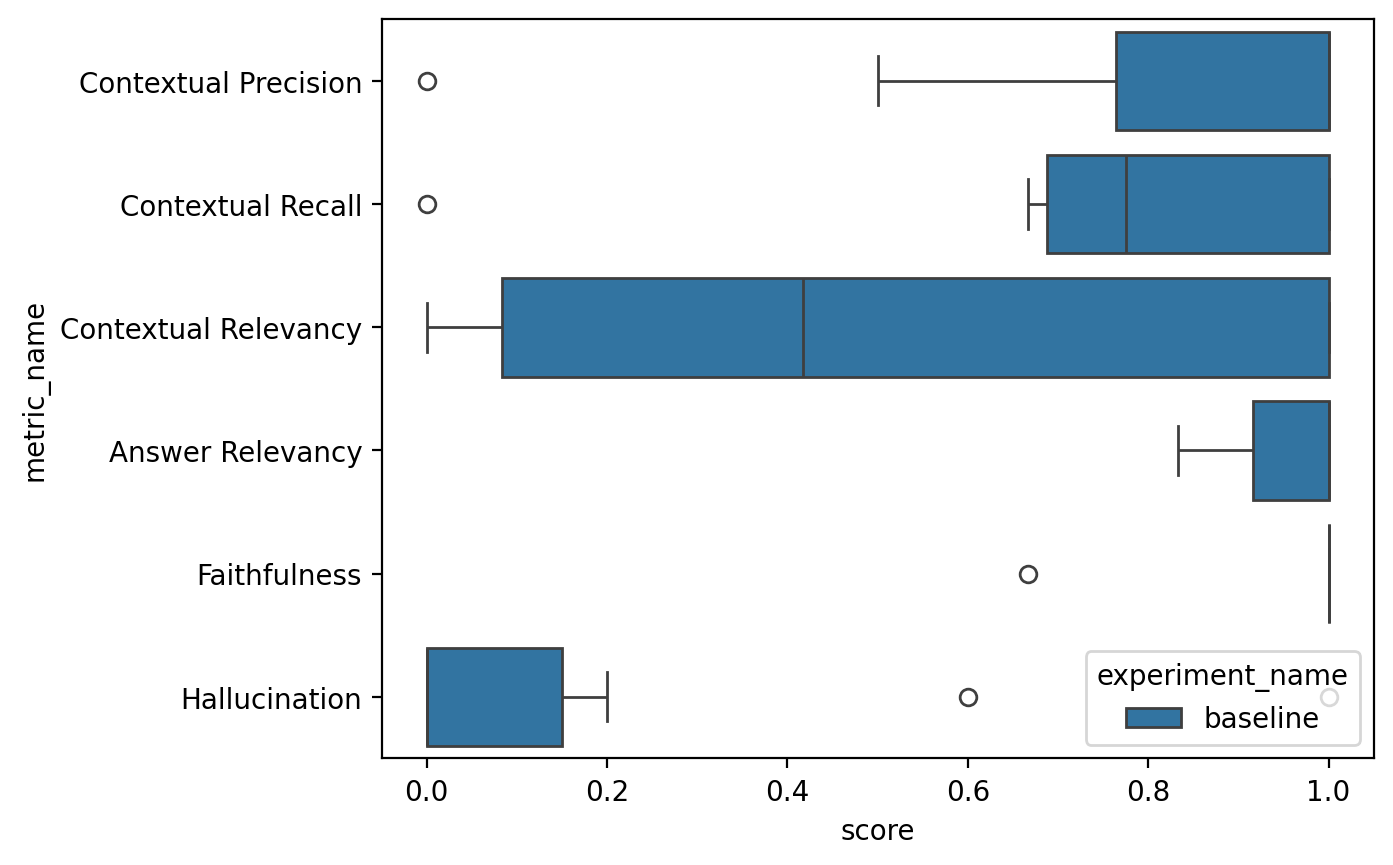

In [114]:
sns.boxplot(experiments_df, x="score", y="metric_name", hue='experiment_name')

**THIS IS THE END OF THE EXPERIMENT**

Return to [HERE](#evaluate) to try a new experiment

The section below is to establish a baseline with the current Core API endpoint only

[Back to top](#title)

-------